In [71]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# Data Cleaning

## Import Long Dataset

In [60]:
# Import longcovid-feb-6.csv and read table
df_original = pd.read_csv("longcovid-feb-8.csv")

# Filter df_original to keep only baseline and visit 2 rows
df_long = df_original[df_original["redcap_event_name"].isin(["baseline_arm_1", "visit_2_arm_1"])].copy()

# Map "baseline_arm_1" to 1 and "visit_2_arm_1" to 2
df_long["visit"] = df_long["redcap_event_name"].map({"baseline_arm_1": 1, "visit_2_arm_1": 2})

# Set intervention groups
df_long.loc[df_long["record_id"] == 1, "interventiongroup"] = 1
df_long.loc[df_long["record_id"] == 2, "interventiongroup"] = 0
df_long.loc[df_long["record_id"] == 3, "interventiongroup"] = 1
df_long.loc[df_long["record_id"] == 4, "interventiongroup"] = 0
df_long.loc[df_long["record_id"] == 5, "interventiongroup"] = 0
df_long.loc[df_long["record_id"] == 6, "interventiongroup"] = 0
df_long.loc[df_long["record_id"] == 7, "interventiongroup"] = 1


# Drop the rows in which record_id is greater than 4
df_long = df_long[df_long["record_id"] <= 4]

# Display the new dataframe
df_long[['record_id', 'visit', 'interventiongroup']].head(15)



,record_id,visit,interventiongroup
1,1,2,1.0
2,1,1,1.0
4,2,2,0.0
5,2,1,0.0
7,3,2,1.0
8,3,1,1.0
10,4,2,0.0
11,4,1,0.0


## Create Variables

In [61]:
# Brainfog
df_long["brainfog"] = (
    df_long["woods_concentration"] + df_long["woods_decisions"] + df_long["woods_confusion"] + 
    df_long["woods_memory"] + df_long["woods_words"] + df_long["woods_takethingsin"] + 
    df_long["woods_processingspeed"] + df_long["woods_thoughtsmixed"] + df_long["woods_muzzy"]
)

# Fatigue
df_long["fatigue"] = (
    df_long["fss_motivation"] + df_long["fss_exercise"] + df_long["fss_easily"] + 
    df_long["fss_functioning"] + df_long["fss_problems"] + df_long["fss_sustained"] + 
    df_long["fss_duties"] + df_long["fss_disabling"] + df_long["fss_social"]
)

# PEM_Frequency
df_long["pem_frequency"] = (
    df_long["dsq_heavy_freq"] + df_long["dsq_nextday_freq"] + df_long["dsq_mentallytired_freq"] + 
    df_long["dsq_minexercise_freq"] + df_long["dsq_drained_freq"]
)

# PEM_Severity
df_long["pem_severity"] = (
    df_long["dsq_heavy_severity"] + df_long["dsq_nextday_severity"] + df_long["dsq_mentallytired_severity"] + 
    df_long["dsq_minexercise_severity"] + df_long["dsq_drained_severity"]
)

# PEM_Total
df_long["pem_total"] = df_long["pem_frequency"] + df_long["pem_severity"]

# PEM_Dichotomous
df_long["pem_dichotomous"] = np.where(
    ((df_long["dsq_heavy_severity"] >= 2) & (df_long["dsq_heavy_freq"] >= 2)) |
    ((df_long["dsq_nextday_severity"] >= 2) & (df_long["dsq_nextday_freq"] >= 2)) |
    ((df_long["dsq_mentallytired_severity"] >= 2) & (df_long["dsq_mentallytired_freq"] >= 2)) |
    ((df_long["dsq_minexercise_severity"] >= 2) & (df_long["dsq_minexercise_freq"] >= 2)) |
    ((df_long["dsq_drained_severity"] >= 2) & (df_long["dsq_drained_freq"] >= 2)),
    1, 0
)

# Sleep Latency (Component 2)
df_long["psqi_latency_score"] = np.select(
    [df_long["psqi_latency"] + df_long["psqi_latency30"] <= 0, 
     (df_long["psqi_latency"] + df_long["psqi_latency30"] > 0) & (df_long["psqi_latency"] + df_long["psqi_latency30"] <= 15), 
     (df_long["psqi_latency"] + df_long["psqi_latency30"] > 15) & (df_long["psqi_latency"] + df_long["psqi_latency30"] <= 30), 
     df_long["psqi_latency"] + df_long["psqi_latency30"] > 30],
    [0, 1, 2, 3]
)

# Sleep Duration (Component 3)
df_long["psqi_duration_score"] = np.select(
    [df_long["psqi_hours"] >= 7, 
     (df_long["psqi_hours"] >= 6) & (df_long["psqi_hours"] < 7), 
     (df_long["psqi_hours"] >= 5) & (df_long["psqi_hours"] < 6), 
     df_long["psqi_hours"] < 5],
    [0, 1, 2, 3]
)

# Habitual Sleep Efficiency (Component 4)
df_long["sleep_efficiency"] = (df_long["psqi_hours"] / (df_long["psqi_sleepend"] - df_long["psqi_sleepstart"])) * 100
df_long["psqi_efficiency_score"] = np.select(
    [df_long["sleep_efficiency"] >= 85, 
     (df_long["sleep_efficiency"] >= 75) & (df_long["sleep_efficiency"] < 85), 
     (df_long["sleep_efficiency"] >= 65) & (df_long["sleep_efficiency"] < 75), 
     df_long["sleep_efficiency"] < 65],
    [0, 1, 2, 3]
)

# Sleep Disturbances (Component 5) - Summing all disturbance variables
disturbance_vars = ["psqi_wake", "psqi_bathroom", "psqi_breathe", "psqi_snore", 
                    "psqi_cold", "psqi_hot", "psqi_dreams", "psqi_pain"]
df_long["psqi_disturbance_score"] = np.select(
    [df_long[disturbance_vars].sum(axis=1) <= 0, 
     df_long[disturbance_vars].sum(axis=1) == 1, 
     df_long[disturbance_vars].sum(axis=1) == 2, 
     df_long[disturbance_vars].sum(axis=1) >= 3],
    [0, 1, 2, 3]
)

# Use of Sleep Medication (Component 6)
df_long["psqi_medication_score"] = np.select(
    [df_long["psqi_medicine"] == 0, 
     df_long["psqi_medicine"] == 1, 
     df_long["psqi_medicine"] == 2, 
     df_long["psqi_medicine"] >= 3],
    [0, 1, 2, 3]
)

# Daytime Dysfunction (Component 7)
df_long["psqi_daytime_dysfunction_score"] = np.select(
    [df_long["psqi_sleepy"] + df_long["psqi_enthusiasm"] <= 0, 
     (df_long["psqi_sleepy"] + df_long["psqi_enthusiasm"] == 1), 
     (df_long["psqi_sleepy"] + df_long["psqi_enthusiasm"] == 2), 
     df_long["psqi_sleepy"] + df_long["psqi_enthusiasm"] >= 3],
    [0, 1, 2, 3]
)

# Global PSQI Score
df_long["psqi_global"] = (
    df_long["psqi_quality"] + df_long["psqi_latency_score"] + df_long["psqi_duration_score"] +
    df_long["psqi_efficiency_score"] + df_long["psqi_disturbance_score"] +
    df_long["psqi_medication_score"] + df_long["psqi_daytime_dysfunction_score"]
)

# Neck Disability Index (NDI)
ndi_vars = ["ndi_intensity", "ndi_personalcare", "ndi_lifting", "ndi_work", 
            "ndi_headaches", "ndi_concentration", "ndi_sleeping", "ndi_driving", 
            "ndi_reading", "ndi_recreation"]
df_long[ndi_vars] = df_long[ndi_vars].apply(pd.to_numeric, errors="coerce")
df_long["ndi_total"] = df_long[ndi_vars].sum(axis=1)
df_long["ndi_percentage"] = (df_long["ndi_total"] / 50) * 100

# Oswestry Disability Index (ODI)
odi_vars = ["odi_intensity", "odi_personalcare", "odi_lifting", "odi_walking", 
            "odi_sitting", "odi_standing", "odi_sleeping", "odi_sex", 
            "odi_social", "odi_traveling"]
df_long[odi_vars] = df_long[odi_vars].apply(pd.to_numeric, errors="coerce")
df_long["odi_total"] = df_long[odi_vars].sum(axis=1)
df_long["odi_percentage"] = (df_long["odi_total"] / 50) * 100

# Anxiety and Depression
gad_vars = ["gad_anxious", "gad_worrying"]
phq_vars = ["phq_hopeless", "phq_anhedonia"]
df_long[gad_vars + phq_vars] = df_long[gad_vars + phq_vars].apply(pd.to_numeric, errors="coerce")
df_long["gad2_total"] = df_long[gad_vars].sum(axis=1)
df_long["phq2_total"] = df_long[phq_vars].sum(axis=1)
df_long["anxiety_dichotomous"] = (df_long["gad2_total"] >= 3).astype(int)
df_long["depression_dichotomous"] = (df_long["phq2_total"] >= 3).astype(int)

# PTSD
ptsd_vars = ["ptsd_nightmares", "ptsd_intrusive", "ptsd_startled", "ptsd_detached", "ptsd_guilty"]
df_long[ptsd_vars] = df_long[ptsd_vars].apply(pd.to_numeric, errors="coerce")
df_long["ptsd_total"] = df_long[ptsd_vars].sum(axis=1)
df_long["ptsd_dichotomous"] = (df_long["ptsd_total"] >= 3).astype(int)

# SFPA
sfpa_vars = [
    "sfpa_vigorous", "sfpa_moderate", "sfpa_lifting", "sfpa_stairs2", "sfpa_stairs1", 
    "sfpa_stooping", "sfpa_walkingmile", "sfpa_walkingblocks2", "sfpa_walkingblocks1", 
    "sfpa_bathingdress"
]
df_long[sfpa_vars] = df_long[sfpa_vars].apply(pd.to_numeric, errors="coerce")
df_long["sfpa_total"] = df_long[sfpa_vars].sum(axis=1)

# Dyspnea
bdi_vars = ["bdi_functional", "bdi_task", "bdi_effort"]
tdi_vars = ["tdi_functional", "tdi_task", "tdi_effort"]
df_long[bdi_vars + tdi_vars] = df_long[bdi_vars + tdi_vars].apply(pd.to_numeric, errors="coerce")
df_long["bdi_total"] = df_long[bdi_vars].sum(axis=1)
df_long["tdi_total"] = df_long[tdi_vars].sum(axis=1)



In [62]:
df_long[['sfpa_total', 'record_id', 'visit']].head(20)

,sfpa_total,record_id,visit
1,27.0,1,2
2,24.0,1,1
4,22.0,2,2
5,23.0,2,1
7,22.0,3,2
8,17.0,3,1
10,29.0,4,2
11,28.0,4,1


## Create Wide Dataset

In [63]:
# Extract unique interventiongroup for each record_id
interventiongroup_df = df_long[["record_id", "interventiongroup"]].drop_duplicates()

# Pivot df_long to create df_wide (excluding interventiongroup from pivot)
df_wide = df_long.pivot(index="record_id", columns="visit", values="sfpa_total").reset_index()

# Rename the columns appropriately
df_wide = df_wide.rename(columns={1: "sfpa_1", 2: "sfpa_2"})

# Merge interventiongroup back
df_wide = df_wide.merge(interventiongroup_df, on="record_id", how="left")

# Create sfpa_change as the difference between sfpa_1 and sfpa_2
df_wide["sfpa_change"] = df_wide["sfpa_2"] - df_wide["sfpa_1"]

# Display the first few rows of df_wide
df_wide.head(10)


,record_id,sfpa_1,sfpa_2,interventiongroup,sfpa_change
0,1,24.0,27.0,1.0,3.0
1,2,23.0,22.0,0.0,-1.0
2,3,17.0,22.0,1.0,5.0
3,4,28.0,29.0,0.0,1.0


# Cross-Sectional Data Analysis

# Pre vs Post

## Loop

## Individual

### SFPA

              Source    SS  DF1  DF2    MS    F     p-unc  np2  eps
0  interventiongroup  18.0    1    2  18.0  0.5  0.552786  0.2  NaN
1              visit   8.0    1    2   8.0  8.0  0.105573  0.8  1.0
2        Interaction   8.0    1    2   8.0  8.0  0.105573  0.8  NaN


              Source    SS  DF1  DF2    MS    F     p-unc  np2  eps
0  interventiongroup  18.0    1    2  18.0  0.5  0.552786  0.2  NaN
1              visit   8.0    1    2   8.0  8.0  0.105573  0.8  1.0
2        Interaction   8.0    1    2   8.0  8.0  0.105573  0.8  NaN
                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       sfpa_total
No. Observations:         8             Method:                   REML      
No. Groups:               4             Scale:                    1.0000    
Min. group size:          2             Log-Likelihood:           -8.1280   
Max. group size:          2             Converged:                Yes       
Mean group size:          2.0                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------

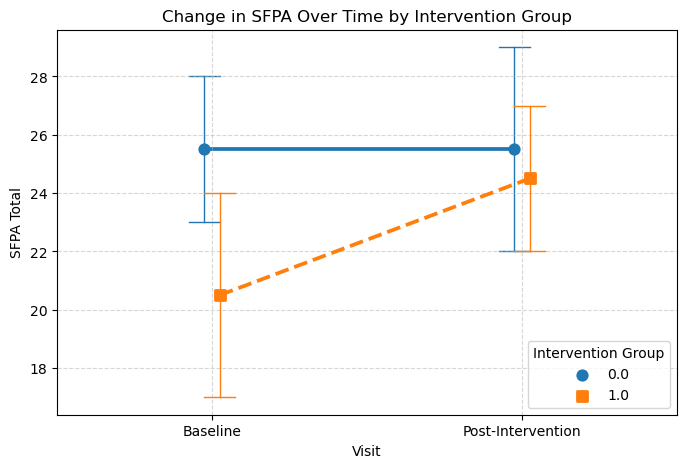

In [76]:
# Run a Mixed (Split Plot) ANOVA comparing the change in SFPA between the two groups
df_anova = df_wide.melt(id_vars=["record_id", "interventiongroup"], value_vars=["sfpa_1", "sfpa_2"], var_name="visit", value_name="sfpa_total")
aov = pg.mixed_anova(dv="sfpa_total", between="interventiongroup", within="visit", subject="record_id", data=df_anova)
print(aov)

# Fit a mixed ANCOVA using sfpa_1 as a covariate
df_anova = df_anova.merge(df_wide[['record_id', 'sfpa_1']], on='record_id')
model = smf.mixedlm("sfpa_total ~ interventiongroup * visit + sfpa_1", 
                    df_anova, 
                    groups=df_anova["record_id"]).fit()
print(model.summary())

# Plot Change Over Time
df_plot = df_wide.melt(id_vars=["record_id", "interventiongroup"], value_vars=["sfpa_1", "sfpa_2"],
                        var_name="visit", value_name="sfpa_total")
df_plot["visit"] = df_plot["visit"].map({"sfpa_1": "Baseline", "sfpa_2": "Post-Intervention"})
plt.figure(figsize=(8, 5))
sns.pointplot(data=df_plot, x="visit", y="sfpa_total", hue="interventiongroup",
              dodge=True, capsize=0.1, errwidth=1, markers=["o", "s"], linestyles=["-", "--"])
plt.title("Change in SFPA Over Time by Intervention Group")
plt.xlabel("Visit")
plt.ylabel("SFPA Total")
plt.legend(title="Intervention Group")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


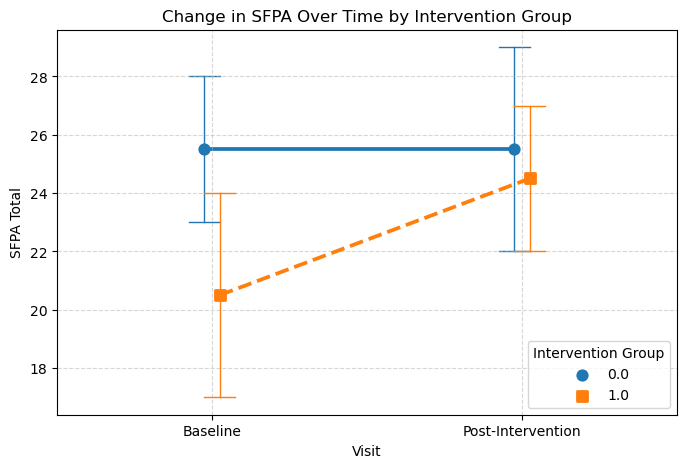